In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

# Part 3: Variational Autoencoders (VAE)

For this part of the lab, you will implement a VAE. There is some code below which will help you run the learning procedure, however, you will need to complete the definition of the loss function. Start by implementing the encoder and decoder for the VAE. There is a diagram below illustrating what these architectures should look like.

Let's start by loading the Fashion-MNIST dataset again and transforming the data to a flattened tensor.

### Loading the Dataset

In [0]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

0it [00:00, ?it/s]

26427392it [00:04, 5657477.96it/s]                              


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 38381.60it/s]                           
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:02, 1623572.42it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 12048.30it/s]            

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Build a Simple Variational Autoencoder

<img src="http://comp6248.ecs.soton.ac.uk/labs/lab8/VAE_resized.png">

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook as tqdm   #######
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer
    and linear projections to the diag-Gauss parameters
    '''
    # YOUR CODE HERE
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1=nn.Linear(input_dim,hidden_dim)
        self.fc21=nn.Linear(hidden_dim,output_dim)
        self.fc22=nn.Linear(hidden_dim,output_dim)
        self.relu=nn.ReLU()
        
    def forward(self, x):
        h = self.fc1(x)
        h1= self.relu(h)
        mu=self.fc21(h1)
        log_sigma2=self.fc22(h1)
        return mu,log_sigma2
    

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    # YOUR CODE HERE
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1=nn.Linear(input_dim,hidden_dim)
        self.fc2=nn.Linear(hidden_dim,output_dim)
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
    
    def forward(self, x):
        h=self.fc1(x)
        h1=self.relu(h)
        out=self.fc2(h1)
        out1=self.sigmoid(out)
        return out1

## You may complete the code below to test your implementation, or alternately, rewrite your own.

#### Please ensure there are some reconstructed images drawn at the bottom of your submitted Juypter notebook to help with the marking process. 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  0


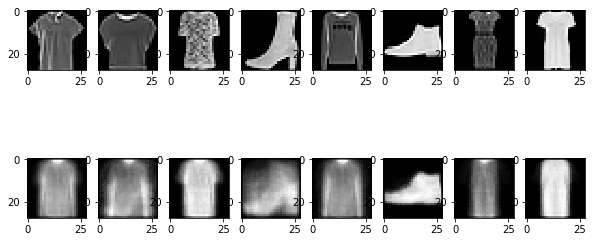


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  1


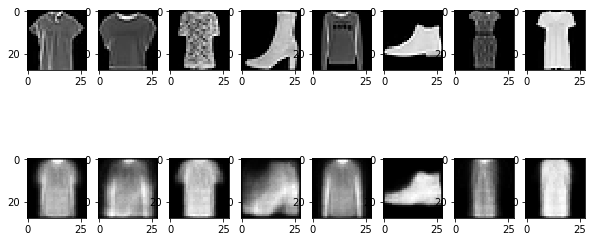


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  2


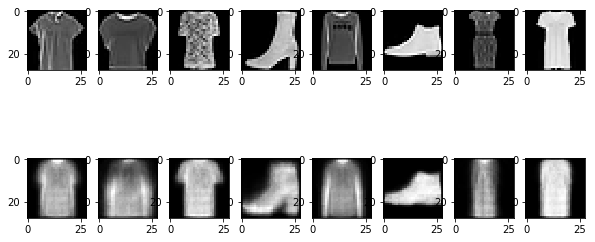


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  3


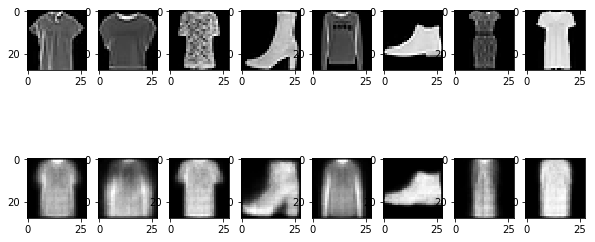


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  4


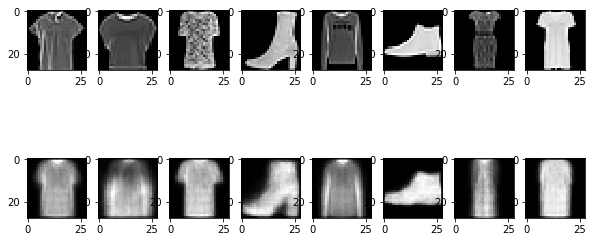


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  5


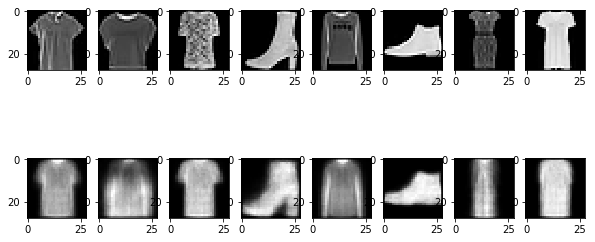


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  6


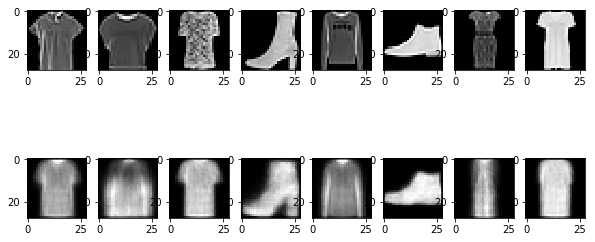


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  7


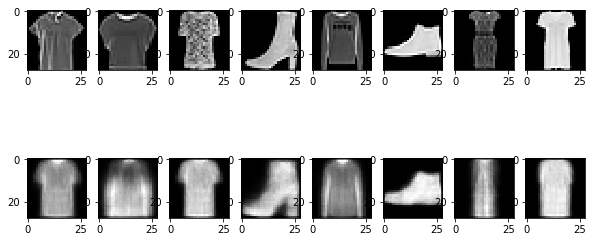


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  8


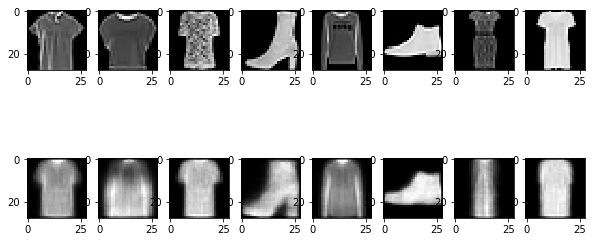


The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder
Epoch:  9


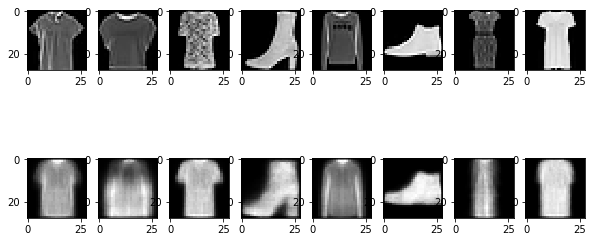

In [0]:
import matplotlib.gridspec as gridspec    
import os
import matplotlib.pyplot as plt

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])  # “standard normal” distribution
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 10

n=8

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# construct the encoder, decoder and optimiser
# enc = Encoder(image_dim, enc_hidden_units, embedding_dim).to(device)
# dec = Decoder(embedding_dim, dec_hidden_units, image_dim).to(device)
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

#         mu, log_sigma2 = enc(inputs.to(device))
        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]  # size_average=False: the losses are instead summed for each minibatch
        
        kl = 0 
        # kl = D_KL(Q(z|X) || P(z|X)) - calculate in closed form
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
#         kl = - 0.5 * torch.sum(1 + log_sigma2 + mu.pow(2) - log_sigma2.exp())
        kld_element = mu.pow(2).add_(log_sigma2.exp()).mul_(-1).add_(1).add_(log_sigma2)
        k1=torch.sum(kld_element).mul_(-0.5)    
    
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)

    
    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE
    print("The first 8 original images of last bacth in each epoch and the reconstructed images after variational autoencoder")
    print('Epoch: ', epoch)
    plt.figure(figsize=(10, 5))
    for j in range(n):
        plt.subplot(2,n,j+1)
        plt.imshow(np.reshape(inputs[j],(28,28)), cmap=plt.get_cmap('gray'))

        plt.subplot(2,n,n+j+1)
        plt.imshow(np.reshape(outputs.data.numpy()[j], (28, 28)), cmap=plt.get_cmap('gray'))

    plt.show()     



**The below is the reconstructed images after variational autoencoder randomly generated from standard normal distribution:**

The reconstructed images after variational autoencoder randomly generated from standard normal distribution:


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


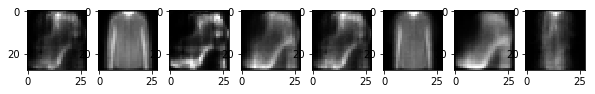

In [0]:
# from torch.autograd import Variable
import matplotlib.pyplot as plt

n = 8
plt.figure(figsize=(10, 5))
print("The reconstructed images after variational autoencoder randomly generated from standard normal distribution:")
with torch.no_grad():
    z = torch.randn(train_set.train_data.shape[0], embedding_dim)  ####### random input vector from standard normal distribution
    view_outputs = dec(z)
    for j in range(n):
        a = plt.subplot(2,n,n+j+1)
        plt.imshow(np.reshape(view_outputs.data.numpy()[j], (28, 28)), cmap=plt.get_cmap('gray'))

    plt.show()